# **Year 3 project - Optimising the stability of a catalyst**

**Data Loading + imports**

In [443]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
initial_df = pd.read_csv(r'C:\Users\Fahim\Yr3-Project-1\Python import.csv')

**Data exploration**

In [444]:
#print(initial_df.head())
print(initial_df.columns)
#print(initial_df.describe())
#print(initial_df.info())

Index(['Catalyst Materials', 'Family', 'Substrate',
       'Operating Conditions (T, pH, potential)', 'Valence state, A',
       'Valence state, B', 'Ionic radius A', 'Ionic radius B', 'ΔGOH*', 'ΔGO*',
       'ΔGOOH*', 'Adsorption strength', 'Stable hours/cycles',
       'Tafel Slope, mV per decade',
       'Overpotential at xx (nearby) current density vs RHE, V',
       'Reaction (HER, HRR, OER, ORR)'],
      dtype='object')


**Data cleaning**

In [445]:
def parse_Nan(dataset):
    parse_datatset = dataset.replace('-',0) 
    parse_datatset = parse_datatset.fillna(0)
    return parse_datatset

In [446]:
initial_df = parse_Nan(initial_df)
columns_to_keep = ["Catalyst Materials","Family","ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
entropy_data = initial_df[columns_to_keep]
columns_to_int = ["ΔGOH*","ΔGO*","ΔGOOH*","Overpotential at xx (nearby) current density vs RHE, V"]
entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']
#print(entropy_data.describe())

C:\Users\Fahim\AppData\Local\Temp\ipykernel_23740\1131857664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data[columns_to_int] = entropy_data[columns_to_int].astype(float)
C:\Users\Fahim\AppData\Local\Temp\ipykernel_23740\1131857664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entropy_data['ΔGO*-ΔGOH*'] = entropy_data['ΔGO*'] - entropy_data['ΔGOH*']


**Preparing first graph**

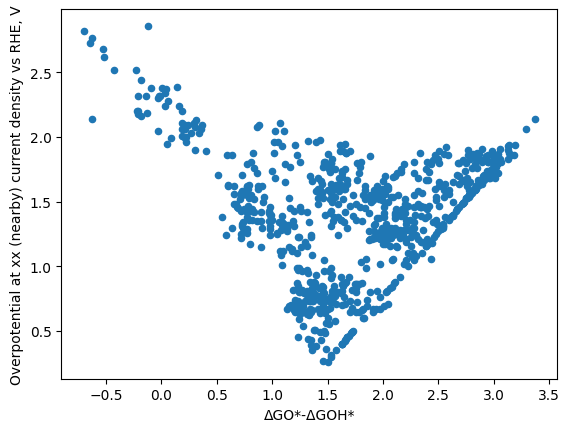

In [447]:
entropy_data = entropy_data.loc[entropy_data["ΔGO*-ΔGOH*"] != 0.0 ]
#print(entropy_data)
entropy_data.plot(x='ΔGO*-ΔGOH*', y = 'Overpotential at xx (nearby) current density vs RHE, V', kind='scatter')
plt.show()

**Clustering**

In [448]:
def elbow_plot(elbow_data):
    k_rng = range(1,10)
    sse = []
    for k in k_rng:
        km = KMeans(n_clusters= k)
        km.fit(elbow_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
        sse.append(km.inertia_)
    plt.xlabel('k')
    plt.ylabel('Sum of squared error')
    plt.plot(k_rng,sse)
    plt.show()

In [449]:
def cluster_df(cluster_df,n_clusters):
    color = ['black','green','purple','red','blue']
    for k in range(0,n_clusters):
        data = cluster_df[cluster_df["cluster"]==k]
        plt.scatter(data['ΔGO*-ΔGOH*'],data["Overpotential at xx (nearby) current density vs RHE, V"],c=color[k])
        print(data['Overpotential at xx (nearby) current density vs RHE, V'].max())
    

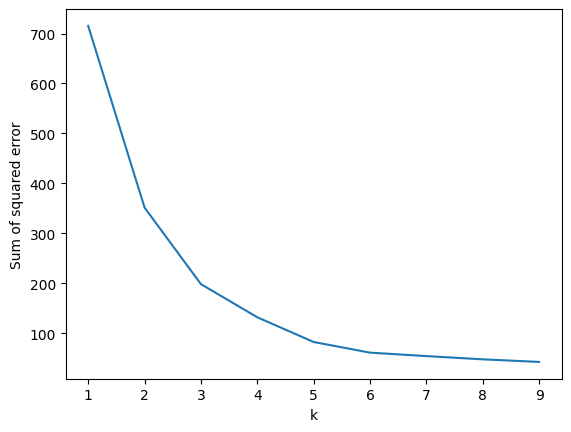

2.11
2.86
2.14
1.89
1.09


Text(0, 0.5, 'Overpotential at xx (nearby) current density vs RHE, V')

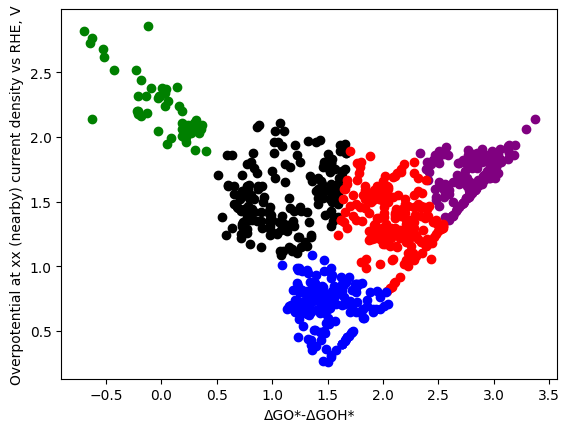

In [450]:
elbow_plot(entropy_data)
km = KMeans(n_clusters= 5)
y_predicted = km.fit_predict(entropy_data[['ΔGO*-ΔGOH*','Overpotential at xx (nearby) current density vs RHE, V']])
entropy_data['cluster'] = y_predicted
cluster_df(entropy_data,5)
plt.xlabel('ΔGO*-ΔGOH*')
plt.ylabel('Overpotential at xx (nearby) current density vs RHE, V')

**Data exploration of clusters**

In [451]:
#Summary statistics on family data on optimum catalysts, catalyst filtered down to our data and the whole initial DF
optimum_catalyst = entropy_data[entropy_data['Overpotential at xx (nearby) current density vs RHE, V']<1.10]
print('The number of families in the optimum catalyst dataset + normalized is:')
print(optimum_catalyst['Family'].value_counts())
print(optimum_catalyst['Family'].value_counts(normalize= True))
print('The number of families in the filtered catalyst dataset + normalized is:')
print(entropy_data['Family'].value_counts())
print(entropy_data['Family'].value_counts(normalize= True))
print('The number of families in the initial catalyst dataset + normalized is:')
print(initial_df['Family'].value_counts())
print(initial_df['Family'].value_counts(normalize= True))
print(optimum_catalyst[optimum_catalyst['Family'] == 'Bimetallic oxide'])

The number of families in the optimum catalyst dataset + normalized is:
Perovskite          176
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.871287
Bimetallic oxide    0.128713
Name: Family, dtype: float64
The number of families in the filtered catalyst dataset + normalized is:
Perovskite          805
Bimetallic oxide     26
Name: Family, dtype: int64
Perovskite          0.968712
Bimetallic oxide    0.031288
Name: Family, dtype: float64
The number of families in the initial catalyst dataset + normalized is:
Perovskite                                     826
0                                               48
Bimetallic oxide                                26
Noble metal                                     23
Transition metal dichalcogenide                 18
Noble metal oxide                               16
2D TMD, 2H                                       9
2D TMD, 1T                                       7
Transition metal phosphide                       4
